In [1]:
import pandas as pd
import os
import numpy as np
import requests
import datetime
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
import datetime
import time
import json
from geopy.geocoders import Nominatim
import matplotlib.pyplot as plt
from matplotlib.patches import Patch
from matplotlib.ticker import MultipleLocator
import openmeteo_requests
import requests_cache
from retry_requests import retry
import hsfs
from pathlib import Path
from dotenv import load_dotenv
import hopsworks
import sys

root_dir = Path().resolve().parent
sys.path.append(str(root_dir))

from format_data import format_weather_data, format_price_data, merge_data
from get_electricity_prices import get_data
from get_weather_data import get_historical_weather, get_weather_forecast

import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score

In [2]:
if not os.getenv("CI"):  # CI is a common variable set in GitHub Actions
    load_dotenv()
hopsworks_api = os.getenv("HOPSWORKS_API_KEY")

os.environ["HOPSWORKS_API_KEY"] = hopsworks_api

project = hopsworks.login()
fs = project.get_feature_store() 
print(f"Connected to project: {project.name}")

2025-01-06 13:59:00,617 INFO: Initializing external client
2025-01-06 13:59:00,617 INFO: Base URL: https://c.app.hopsworks.ai:443
2025-01-06 13:59:02,100 INFO: Python Engine initialized.

Logged in to project, explore it here https://c.app.hopsworks.ai:443/p/1164446
Connected to project: oskaralf


In [3]:
feature_view = fs.get_feature_view(
    name='electricity_price_fv_3',
    version=1,
)

In [4]:
mr = project.get_model_registry()

retrieved_model = mr.get_model(
    name="electricity_xgboost_model_se3",
    version=1,
)
saved_model_dir = retrieved_model.download()

In [5]:
saved_model_dir
retrieved_xgboost_model = xgb.XGBRegressor()
retrieved_xgboost_model.load_model(saved_model_dir + "/model_se3.json")
retrieved_xgboost_model

XGBRegressor(base_score='8.8648735E1', booster='gbtree', callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None,
             feature_types=['float', 'float', 'float', 'float', 'float',
                            'float'],
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=None, n_jobs=None,
             num_parallel_tree=None, random_state=None, ...)

In [13]:
weather_fg = fs.get_feature_group(
    name='weather_data_3',
    version=1,
)
entsoe_fg = fs.get_feature_group(
    name='entsoe_data_3',
    version=1,
)
entsoe_fg = fs.get_feature_group(name='entsoe_data_3', version=1)
weather_fg = fs.get_feature_group(name='weather_data_3', version=1)

# Read the data from the feature groups into pandas DataFrames
entsoe_df = entsoe_fg.read()
weather_df = weather_fg.read()

# Ensure 'date' columns are of the same datetime64[ns] type and timezone
entsoe_df['date'] = pd.to_datetime(entsoe_df['date']).dt.tz_convert('UTC')
weather_df['date'] = pd.to_datetime(weather_df['date']).dt.tz_convert('UTC')

last_date = entsoe_df['date'].max()
print("Last date in the entsoe data:", last_date)
#batch_data = pd.merge(weather_data, entsoe_data, on='date', how='inner')
#print(weather_df[(weather_df['date'] >= last_date - pd.Timedelta(hours=1)) & 
                 #(weather_df['date'] <= last_date + pd.Timedelta(hours=1))]['date'])

weather_data = weather_fg.filter((weather_fg['date'] >= last_date - pd.Timedelta(hours=1)) & 
                                 (weather_fg['date'] <= last_date + pd.Timedelta(hours=1))).read()
#batch_data

Finished: Reading data from Hopsworks, using Hopsworks Feature Query Service (1.83s) 
Finished: Reading data from Hopsworks, using Hopsworks Feature Query Service (1.00s) 
Last date in the entsoe data: 2025-01-06 12:00:00+00:00
Finished: Reading data from Hopsworks, using Hopsworks Feature Query Service (0.62s) 


In [14]:
print(weather_data)

                       date  temperature_2m  precipitation  snow_depth  \
0 2025-01-06 12:00:00+00:00          1.4175            0.0        0.06   
1 2025-01-06 14:00:00+00:00          1.3675            0.0        0.06   
2 2025-01-06 13:00:00+00:00          1.5175            0.0        0.06   

   pressure_msl  cloud_cover  wind_speed_10m  wind_speed_100m  \
0    996.799988        100.0       22.319998        33.973778   
1    995.500000        100.0       23.400000        36.659946   
2    996.299988        100.0       21.959999        35.501549   

   wind_direction_10m  wind_direction_100m       city  
0               121.0           115.750427  Stockholm  
1               110.0           107.723328  Stockholm  
2               118.0           112.664597  Stockholm  


In [15]:
batch_data = pd.merge(weather_data, entsoe_df, on='date', how='inner')

In [16]:
print(batch_data)

                       date  temperature_2m  precipitation  snow_depth  \
0 2025-01-06 12:00:00+00:00          1.4175            0.0        0.06   

   pressure_msl  cloud_cover  wind_speed_10m  wind_speed_100m  \
0    996.799988        100.0       22.319998        33.973778   

   wind_direction_10m  wind_direction_100m  ... total_generation_solar  \
0               121.0           115.750427  ...                   75.0   

   total_generation_waste  total_generation_wind_offshore  \
0                    36.0                          1436.0   

   total_generation_wind_onshore  flows_se3_to_finland  flows_finland_to_se3  \
0                         2512.0                1194.0                   0.0   

   flows_se3_to_norway  flows_norway_to_se3  flows_se3_to_denmark  \
0                217.0                  0.0                  67.0   

   flows_denmark_to_se3  
0                   0.0  

[1 rows x 32 columns]


In [17]:
def modify_dataframe(df):
    # Define the columns to be merged for imported_energy
    columns_to_merge = [
        'flows_se3_to_finland', 'flows_finland_to_se3',
        'flows_se3_to_norway', 'flows_norway_to_se3',
        'flows_se3_to_denmark', 'flows_denmark_to_se3'
    ]

    df['imported_energy'] = df.apply(
        lambda row: sum(-row[col] if 'se3_to' in col else row[col] for col in columns_to_merge),
        axis=1
    )

    df = df.drop(columns=columns_to_merge)

    df['total_load'] = ( df['load_finland'] +
        df['load_norway'] + df['load_denmark'] + df['load_se3']
    )

    df = df.drop(columns=['load_finland', 'load_norway', 'load_denmark', 'load_se3'])

    columns_to_sum = [
        'total_generation_biomass', 'total_generation_fossil_gas',
        'total_generation_fossil_hard_coal', 'total_generation_fossil_oil',
        'total_generation_hydro_run_of_river_and_poundage',
        'total_generation_other_renewable', 'total_generation_solar',
        'total_generation_waste', 'total_generation_wind_offshore',
        'total_generation_wind_onshore'
    ]

    df['total_generation_se'] = df[columns_to_sum].sum(axis=1)
    df = df.drop(columns=columns_to_sum)

    return df

In [18]:
batch_data = modify_dataframe(batch_data)

In [19]:
print(batch_data.columns)
print(batch_data)

Index(['date', 'temperature_2m', 'precipitation', 'snow_depth', 'pressure_msl',
       'cloud_cover', 'wind_speed_10m', 'wind_speed_100m',
       'wind_direction_10m', 'wind_direction_100m', 'city', 'prices',
       'imported_energy', 'total_load', 'total_generation_se'],
      dtype='object')
                       date  temperature_2m  precipitation  snow_depth  \
0 2025-01-06 12:00:00+00:00          1.4175            0.0        0.06   

   pressure_msl  cloud_cover  wind_speed_10m  wind_speed_100m  \
0    996.799988        100.0       22.319998        33.973778   

   wind_direction_10m  wind_direction_100m       city  prices  \
0               121.0           115.750427  Stockholm   31.28   

   imported_energy  total_load  total_generation_se  
0          -1478.0    35170.75               4401.0  


In [20]:
batch_data = batch_data.drop(columns = ['snow_depth',
       'pressure_msl', 'cloud_cover', 'prices', 'wind_speed_10m',
       'wind_direction_10m', 'wind_direction_100m', 'city'])

In [21]:
print(batch_data.columns)

Index(['date', 'temperature_2m', 'precipitation', 'wind_speed_100m',
       'imported_energy', 'total_load', 'total_generation_se'],
      dtype='object')


In [22]:
print(batch_data)

                       date  temperature_2m  precipitation  wind_speed_100m  \
0 2025-01-06 12:00:00+00:00          1.4175            0.0        33.973778   

   imported_energy  total_load  total_generation_se  
0          -1478.0    35170.75               4401.0  


In [23]:
column_order = ['date','temperature_2m', 
'precipitation', 'wind_speed_100m', 'imported_energy', 
'total_load', 'total_generation_se']

batch_data = batch_data[column_order]

In [24]:
print(batch_data)

                       date  temperature_2m  precipitation  wind_speed_100m  \
0 2025-01-06 12:00:00+00:00          1.4175            0.0        33.973778   

   imported_energy  total_load  total_generation_se  
0          -1478.0    35170.75               4401.0  


In [25]:
batch_data['predicted_electricity_price'] = retrieved_xgboost_model.predict(
    batch_data[['temperature_2m', 'precipitation', 'wind_speed_100m', 'imported_energy',
       'total_load', 'total_generation_se']])
batch_data

,date,temperature_2m,precipitation,wind_speed_100m,imported_energy,total_load,total_generation_se,predicted_electricity_price
0,2025-01-06 12:00:00+00:00,1.4175,0.0,33.973778,-1478.0,35170.75,4401.0,57.353424


In [26]:
batch_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1 entries, 0 to 0
Data columns (total 8 columns):
 #   Column                       Non-Null Count  Dtype                  
---  ------                       --------------  -----                  
 0   date                         1 non-null      datetime64[us, Etc/UTC]
 1   temperature_2m               1 non-null      float32                
 2   precipitation                1 non-null      float32                
 3   wind_speed_100m              1 non-null      float32                
 4   imported_energy              1 non-null      float64                
 5   total_load                   1 non-null      float64                
 6   total_generation_se          1 non-null      float64                
 7   predicted_electricity_price  1 non-null      float32                
dtypes: datetime64[us, Etc/UTC](1), float32(4), float64(3)
memory usage: 180.0 bytes


In [29]:
monitor_fg = fs.get_or_create_feature_group(
    name='electricity_prediction_fg',
    version=1,
    primary_key=['date'],
    description='Predicted electricity prices for SE3',
    event_time='date',
)

In [30]:
print(batch_data)

                       date  temperature_2m  precipitation  wind_speed_100m  \
0 2025-01-06 12:00:00+00:00          1.4175            0.0        33.973778   

   imported_energy  total_load  total_generation_se  \
0          -1478.0    35170.75               4401.0   

   predicted_electricity_price  
0                    57.353424  


In [34]:
monitor_fg.insert(batch_data)

Uploading Dataframe: 100.00% |██████████| Rows 1/1 | Elapsed Time: 00:02 | Remaining Time: 00:00


2025-01-06 14:03:29,070 WARNING: UserWarning: Materialization job is already running, aborting new execution.Please wait for the current execution to finish before triggering a new one.You can check the status of the current execution using `fg.materialization_job.get_state()`.or `fg.materialization_job.get_final_state()` or check it out in the Hopsworks UI.at https://c.app.hopsworks.ai:443/p/1164446/jobs/named/electricity_prediction_fg_1_offline_fg_materialization.
Use fg.materialization_job.run(args=-op offline_fg_materialization -path hdfs:///Projects/oskaralf/Resources/jobs/electricity_prediction_fg_1_offline_fg_materialization/config_1736162539300) to trigger the materialization job again.



(Job('electricity_prediction_fg_1_offline_fg_materialization', 'SPARK'), None)

In [35]:
plot_data = monitor_fg.read()
print(plot_data)

Finished: Reading data from Hopsworks, using Hopsworks Feature Query Service (3.86s) 
                       date  temperature_2m  precipitation  wind_speed_100m  \
0 2025-01-06 10:00:00+00:00          0.5175            0.0        37.064270   
1 2025-01-06 11:00:00+00:00          1.2175            0.0        35.603615   
2 2025-01-06 12:00:00+00:00          1.4175            0.0        33.973778   

   imported_energy  total_load  total_generation_se  \
0          -1212.0    35122.75               4456.0   
1          -1351.0    35247.25               4374.0   
2          -1478.0    35170.75               4401.0   

   predicted_electricity_price  
0                    61.533527  
1                    60.784996  
2                    57.353424  


2025-01-06 14:03:43,476 WARNING: DeprecationWarning: backend2gui is deprecated since IPython 8.24, backends are managed in matplotlib and can be externally registered.



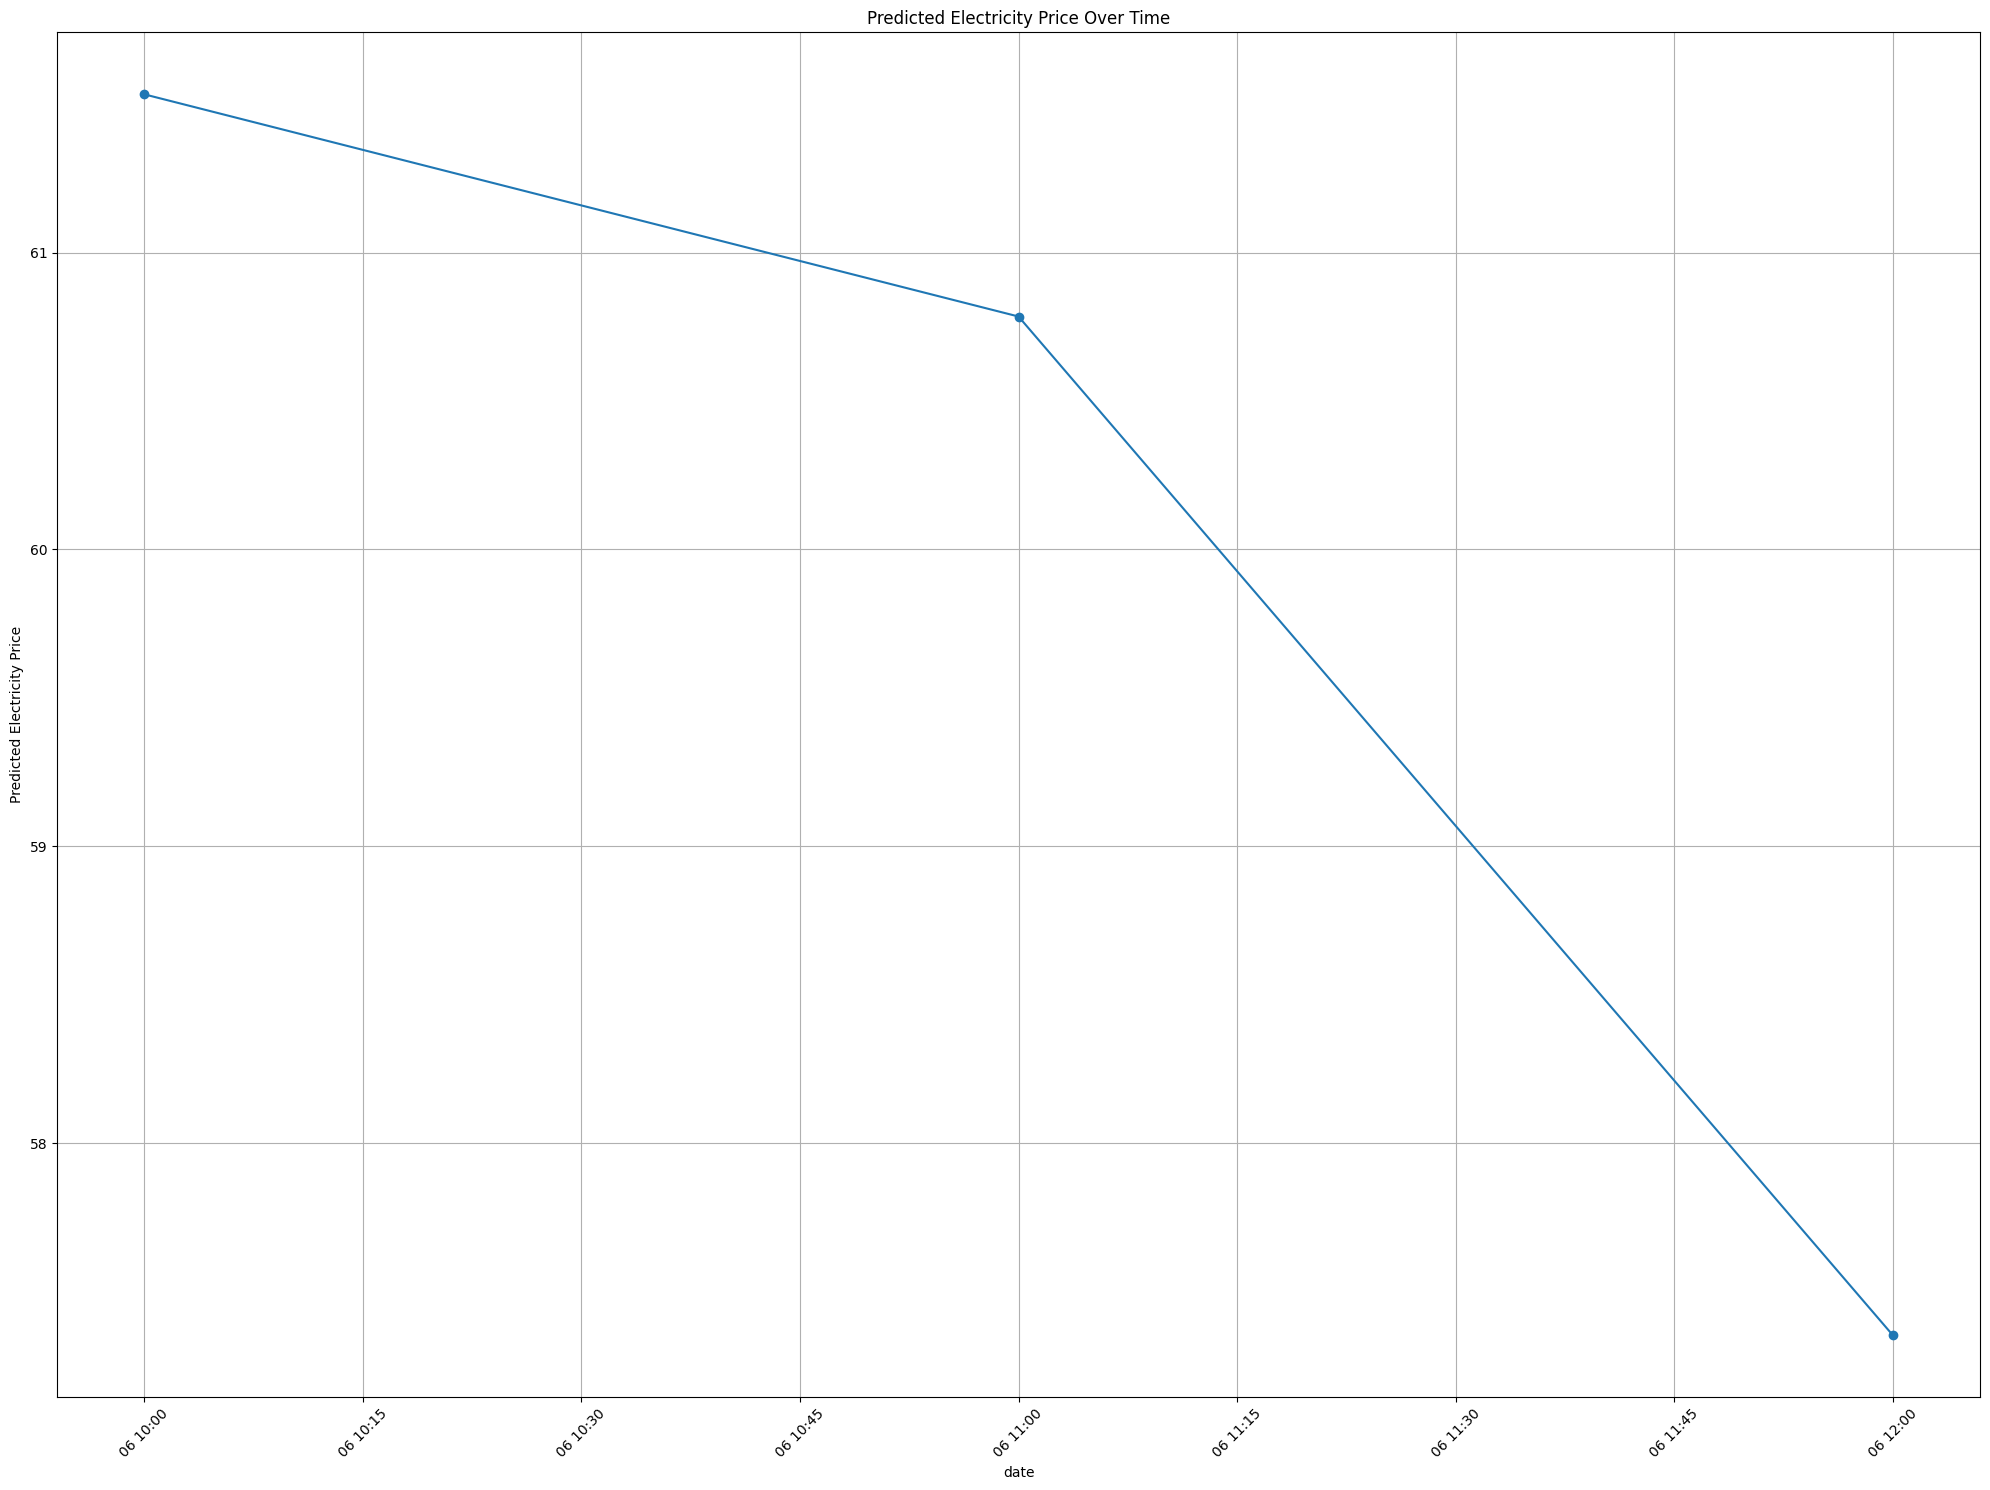

In [36]:

#batch_data['time_start'] = pd.to_datetime(batch_data['time_start'], errors='coerce')
#batch_data = batch_data.sort_values(by='date')

# if batch_data['time_start'].isnull().any():
#     raise ValueError("Some 'time_start' values could not be converted to datetime.")
#if 'predicted_electricity_price' not in batch_data.columns:
    #raise KeyError("'predicted_electricity_price' column does not exist in the DataFrame")

plt.figure(figsize=(20, 15))
plt.plot(plot_data['date'], plot_data['predicted_electricity_price'], marker='o')
plt.xlabel('date')
plt.ylabel('Predicted Electricity Price')
plt.title('Predicted Electricity Price Over Time')
plt.xticks(rotation=45)
plt.grid(True)
plt.tight_layout()


output_dir = 'Images/'
os.makedirs(output_dir, exist_ok=True)
output_path = os.path.join(output_dir, 'predicted_electricity_price_over_time_SE4.png')
plt.savefig(output_path)

plt.show()